# Logistic growth model

In this example, we use the logistic growth model in order to show how to define a function which has a vector input and a field output. We use the `OpenTURNSPythonPointToFieldFunction` class to define the derived class and its methods. 

## Introduction

The logistic growth model is the differential equation:

$$
\frac{dy(t)}{dt} = ay(t) - by(t)^2
$$

for any $t\in[t_0, t_{final}]$, with the initial condition:

$$
y(t_0) = y_0
$$

where

- $a > 0$ and $b > 0$ are two real parameters, 
- $y(t)$ is the size of the population at time $t$, 
- $t_0$ is the initial time,
- $y_0$ is the initial population at time $t=t_0$, 
- $t_{final}$ is the final time.

The $a$ parameter sets the growth rate of the population. The $b$ parameter acts as a competition parameter which limits the size of the population by increasing the competition between its members. 

In [1], the author uses this model to simulate the growth of the U.S. population. To do this, the author uses the U.S. census data from 1790 to 1910. For this time interval, R. Pearl and L. Reed [2] computed the following values of the parameters:

$$
a = 0.03134, \qquad 
b = 1.5887 \times 10^{-10}.
$$

Our goal is to use the logistic growth model in order to simulate the solution for a larger time interval, from 1790 to 2000:

$$
t_0 = 1790, \qquad 
t_{final} = 2000.
$$

Then we can compare the predictions of this model with the real evolution of the U.S. population.

We can prove that, if $y_0 > 0$, then the limit population is:

$$
y_{limit} =\frac{a}{b}.
$$

In 1790, the U.S. population was 3.9 Millions inhabitants:

$$
y_0 = 3.9 \times 10^6.
$$

We can prove that the exact solution of the ordinary differential equation is:

$$
y(t)=\frac{ay_0}{by_0+(a-by_0 ) \exp(-a(t-t_0)) }
$$

for any $t\in[t_0, t_{final}]$.

We want to see the solution of the ordinary differential equation when uncertainties are taken into account in the parameters:

- the initial U.S. population $y_0$,
- the parameters $a$ and $b$.

Indeed, Pearl and Reed [2] estimated the parameters $a$ and $b$ using the U.S. census data from 1790 to 1910 while we have the data up to 2000. Moreover, the method used by Pearl and Reed to estimate the parameters could be improved; they only used 3 dates to estimate the parameters instead of using least squares, for example. Finally, Pearl and Reed did not provide confidence intervals for the parameters $a$ and $b$. 


## Normalizing the data

The order of magnitude of the population is $10^6$. This is why we consider the normalized population in millions:

$$
z(t) = \frac{y(t)}{10^6}
$$

for any $t\in[t_0, t_{final}]$.

## Uncertainties

We consider that the parameters $z_0$, $a$, $b$ are independent random variables with the following gaussian distributions.

|Variable|  Distribution|
| ------------- |-------------|
| $Z_0$ | gaussian, mean $z_0$, coefficient of variation 10% |
| $A$ | gaussian, mean $a$, coefficient of variation 30% |
| $C$ | gaussian, mean $c$, coefficient of variation 30% |

These parameters have been set without any particular probabilistic method. An improvement would be to use calibration methods to get a better quantification of these distributions. 

## Notes

* This example is based on [1], chapter "First order differential equations", page 28. 
The data used in [1] are from [3]. 
The logistic growth model was first suggested by Pierre François Verhulst near 1840. 
The data are from [1] for the time interval from 1790 to 1950, then from [2] for the time interval from 1960 to 2000.
* Calibrating this model may require to take into account for the time dependency of the measures.

## References

[1] Martin Braun. Differential equations and their applications, Fourth Edition. Texts in applied
mathematics. Springer, 1993.

[2] Cleve Moler. Numerical Computing with Matlab. Society for Industrial Applied Mathematics,
2004.

[3] Raymond Pearl and Lowell Reed. On the rate of growth of the population of the united states
since 1790 and its mathematical representation. Proceedings of the National Academy of Sciences,
1920.

## Define the model

In [1]:
from __future__ import print_function
import openturns as ot
from numpy import linspace, exp, maximum

In [2]:
# Some data
ustime=list(range(1790,2001,10))
uspop=[3.9,5.3,7.2,9.6,13.,17.,23.,31.,39., 50.,62.,76.,92.,106.,123.,132.,151.,179., 203.,221.,250.,281.]

In [3]:
# Creation of the input distribution
y0 = 3.9e6
a = 0.03134
b = 1.5887e-10
distY0 = ot.Normal(y0, 0.1 * y0)
distA  = ot.Normal(a, 0.3 * a)
distB  = ot.Normal(b, 0.3 * b)
distX = ot.ComposedDistribution([distY0, distA, distB])

In [4]:
# The model
class Popu(ot.OpenTURNSPythonPointToFieldFunction):

    def __init__(self, t0 = 1790.0, tfinal = 2000.0, nt = 1000):
        grid = ot.RegularGrid(t0, (tfinal - t0) / (nt - 1), nt)
        super(Popu, self).__init__(3, grid, 1)
        self.setInputDescription(['y0', 'a', 'b'])
        self.setOutputDescription(['N'])
        self.ticks_ = [t[0] for t in grid.getVertices()]
        self.phi_ = ot.SymbolicFunction(['t', 'y', 'a', 'b'], ['a*y - b*y^2'])
        
    def _exec(self, X):
        y0 = X[0]
        a  = X[1]
        b  = X[2]
        phi_ab = ot.ParametricFunction(self.phi_, [2, 3], [a, b])
        phi_t = ot.ParametricFunction(phi_ab, [0], [0.0])
        solver = ot.RungeKutta(phi_t)
        initialState = [y0]
        values = solver.solve(initialState, self.ticks_)
        return values * [1.0e-6]

F = Popu(1790.0, 2000.0, 1000)
popu = ot.PointToFieldFunction(F)

## Generate a sample from the model

In [5]:
# Sample the model
size = 10
inputSample = distX.getSample(size)
outputSample = popu(inputSample)

In [6]:
ot.ResourceMap.SetAsUnsignedInteger('Drawable-DefaultPalettePhase', size)

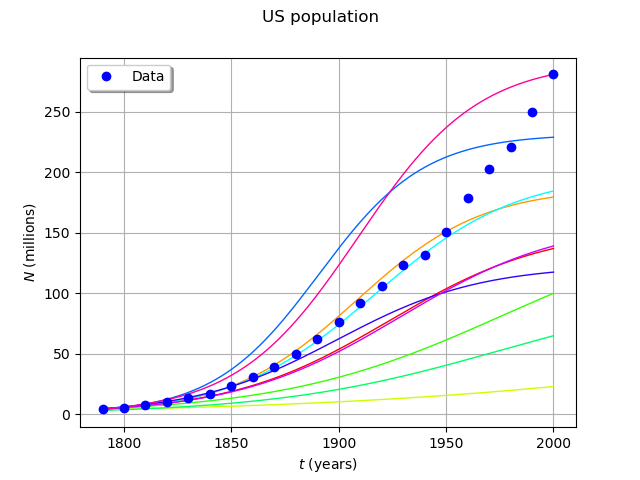

In [7]:
# Draw some curves
graph = outputSample.drawMarginal(0)
graph.setTitle('US population')
graph.setXTitle(r'$t$ (years)')
graph.setYTitle(r'$N$ (millions)')
cloud = ot.Cloud(ustime, uspop)
cloud.setPointStyle('circle')
cloud.setLegend('Data')
graph.add(cloud)
graph.setLegendPosition('topleft')
graph
